In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog

In [45]:
# HELPER CLASS TO HANDLE DATA SET AND TRAIN, TEST IMGAGES

class data_handle():
    
    # INITIALIZE DATA SET, CLASS AND LABELS
    def __init__(self, path = "../"):
        np.random.seed()
        # DATA
        self.data = pd.read_csv(path + "Data_Entry_2017.csv").values
        
        # CLASS COUNT & LABELS
        self.classes = dict()
        self.labels = dict()
        
        for i in range(self.data.shape[0]):
            items = self.data[i, 1].split('|')
            for j in items:
                self.classes[j] = self.classes.get(j, 0) + 1
                if j not in self.labels:
                    self.labels[j] = len(self.labels)
        
        # TRAIN LIST
        self.train_file = open(path+"train_val_list.txt", "r")
        self.train = list()
        for x in self.train_file:
            y = x.rstrip("\n")
            self.train.append(y)
        
        # TEST LIST
        self.test_file = open(path+"test_list.txt", "r")
        self.test = list()
        for x in self.test_file:
            y = x.rstrip("\n")
            self.test.append(y)
        
    # EXTRACT N RANDOM NUMBER OF CLASSES
    def extract_random_train_samples(self, n = 100, include = np.arange(0,15)):
        np.random.seed()
        train = np.empty((1,2))
        for x, y in self.labels.items():
            if(y not in include):
                continue
            # FIND CLASS FROM DATA_LIST
            idx = np.where(np.char.find(list(self.data[:, 1]), str(x)) >=0)
            data_sub = self.data[idx, 0]
            data_sub = data_sub[0]
            # RANDOM N SAMPLES
            if(self.classes[x] > n):
                data_sub = np.random.choice(data_sub, n)
            data_sub = data_sub.reshape((data_sub.shape[0], 1))
            lab = int(y)*np.ones((data_sub.shape[0], 1), dtype=np.int8)
            data_sub = np.hstack((data_sub, lab))
            train = np.vstack((train, data_sub))

        return train[1:, :]
    
    # OUTPUTS IMAGE PIXELS
    def find_img(self, img, path="../images/"):
        return plt.imread(path+img)
        
    # CROP X AND Y PIXELS FROM CENTER 
    def center_crop(self, img, x = 800, y = 800):
        xx = img.shape[1]
        yy = img.shape[0]
        img_out = img[int(yy/2-y/2):int(yy/2+y/2), int(xx/2-x/2):int(xx/2+x/2)]
        return img_out
    
    # SCALE IMAGE
    def resize(self, img, val=1024):
        return cv2.resize(img, (val, val), interpolation=cv2.INTER_LINEAR)
    
    # HOG feature
    def hog_img(self, img, cell_size = (8,8), o = 9):
        return hog(img, orientations=o, pixels_per_cell=cell_size, cells_per_block=(2, 2), feature_vector=True)
        
    # GENERATE N NUMBER SAMPLES PER CLASS, PREPROCESS AND OUTPUT LEARNING MATRICES 
    # TODO: ADD FEATURE EXTRACTION AND MAYBE PCA??
    def featurize(self, crop=800, resize=256, n=100, h = False, include = np.arange(0,15), all_data = False):
        train_list = self.extract_random_train_samples(n, include)
        # X is the feature vector
        X = 0
        del_list = list()
        for x in range(train_list.shape[0]):
            file_name = train_list[x, 0]
            img = self.find_img(file_name, "../images/")
            # CROP, RESIZE AND FLATTEN IMG
            img = self.center_crop(img, crop, crop)
            img_scaled = self.resize(img, resize)

            if not h:
                img = img_scaled.flatten()
                # WEIRD ERROR HERE WHERE IMG NOT SCALING ON CERTAIN IMAGES SO HARD DELETE
                if(img.shape[0] == 512*512):
                    del_list.append(x)
                    continue
                img = img.reshape((1, img.shape[0]))

            # HOG img
            else:
                img = self.hog_img(img_scaled)
                img = img.reshape((1, img.shape[0]))
                
            if(x == 0):
                X = img
            else:         
                X = np.vstack((X, img))
        y = train_list[:, 1]   
        y = np.delete(y, del_list, 0)
        
        return X, y.astype('int')
            
    
    ####### VISUALIZATIONS #######
    
    def plot_bar(self, stuff):
        lists = sorted(stuff.items())
        x, y = zip(*lists)
        fig, ax = plt.subplots()
        ax.bar(x, y)
        fig.autofmt_xdate()
        plt.show()
        
    # CROPPED AND RESIZED TO 750X750 AND TO 256X256 RESPECTIVELY
    def view_class_examples(self, path="../images/", crop=800, res=256):
        
        for x in self.classes:
            idx = np.where(np.char.find(list(self.data[:, 1]), str(x)) >=0)
            data_sub = self.data[idx, 0]
            img_s = np.random.choice(data_sub[0], 1)
            print("Class: {}".format(x))
            
            plt.figure()
            img = plt.imread(path+img_s[0])
            img = self.center_crop(img, crop, crop)
            img = self.resize(img, res)
            plt.imshow(img, cmap="gray")
            plt.show()
            print("\n")

In [46]:
d = data_handle()
labels = d.labels
classes = d.classes

print("Labels: {}\n".format(labels))
print("Classes: {}\n".format(classes))

Labels: {'Cardiomegaly': 0, 'Emphysema': 1, 'Effusion': 2, 'No Finding': 3, 'Hernia': 4, 'Infiltration': 5, 'Mass': 6, 'Nodule': 7, 'Atelectasis': 8, 'Pneumothorax': 9, 'Pleural_Thickening': 10, 'Pneumonia': 11, 'Fibrosis': 12, 'Edema': 13, 'Consolidation': 14}

Classes: {'Cardiomegaly': 2776, 'Emphysema': 2516, 'Effusion': 13317, 'No Finding': 60361, 'Hernia': 227, 'Infiltration': 19894, 'Mass': 5782, 'Nodule': 6331, 'Atelectasis': 11559, 'Pneumothorax': 5302, 'Pleural_Thickening': 3385, 'Pneumonia': 1431, 'Fibrosis': 1686, 'Edema': 2303, 'Consolidation': 4667}



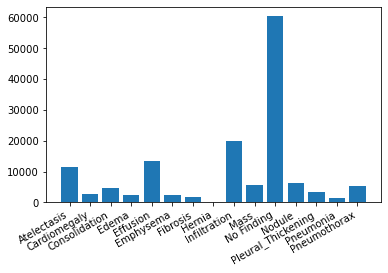

In [47]:
d.plot_bar(classes)

Class: Cardiomegaly


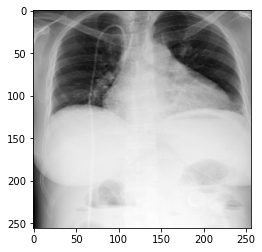



Class: Emphysema


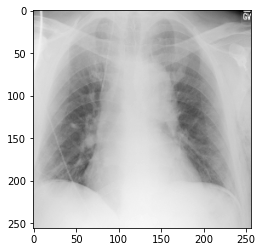



Class: Effusion


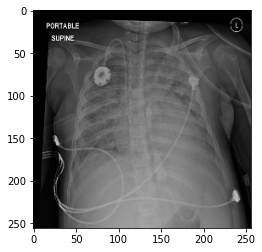



Class: No Finding


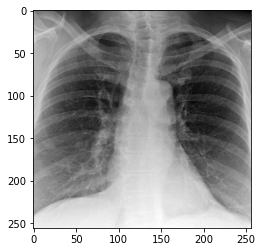



Class: Hernia


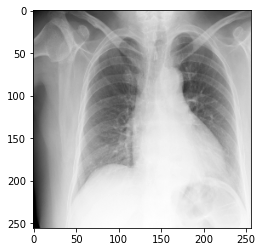



Class: Infiltration


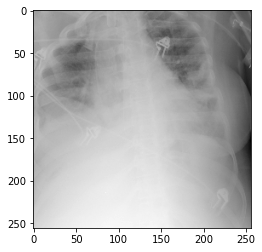



Class: Mass


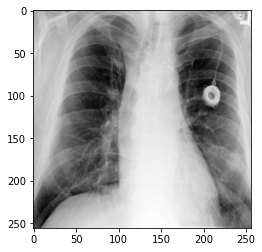



Class: Nodule


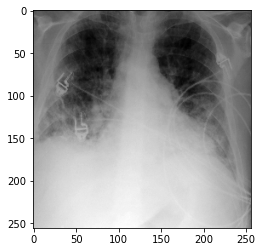



Class: Atelectasis


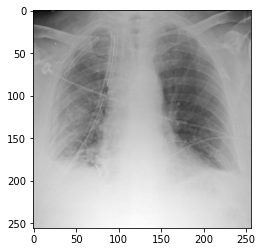



Class: Pneumothorax


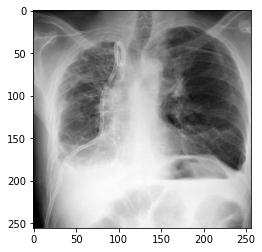



Class: Pleural_Thickening


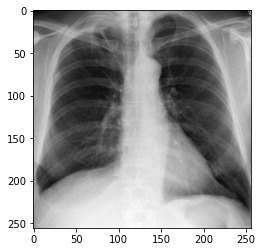



Class: Pneumonia


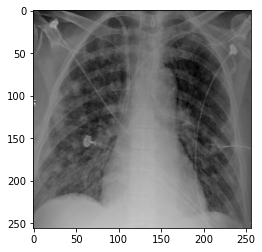



Class: Fibrosis


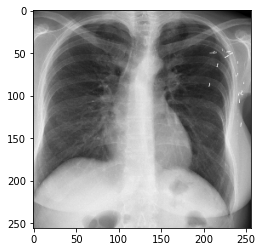



Class: Edema


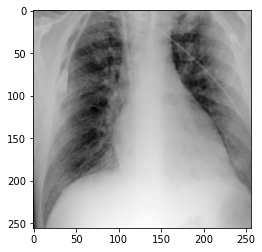



Class: Consolidation


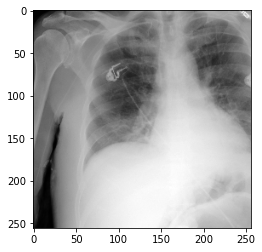

In [48]:
d.view_class_examples()

In [49]:
data_sub = d.extract_random_train_samples(50)
print(data_sub)

[['00001268_000.png' 0]
 ['00013616_043.png' 0]
 ['00012505_008.png' 0]
 ...
 ['00001255_019.png' 14]
 ['00018867_036.png' 14]
 ['00014346_006.png' 14]]


In [50]:
X, y = d.featurize(n=2, h=True, include=(2,5,6,7,8,9))
print(X)
print(y)

[[0.10565779 0.13053445 0.2857494  ... 0.         0.         0.        ]
 [0.25733716 0.10021344 0.2834549  ... 0.02337831 0.1667341  0.2493792 ]
 [0.03005016 0.09079702 0.00514992 ... 0.09565977 0.2569423  0.2569423 ]
 ...
 [0.02592499 0.00895161 0.04343504 ... 0.34941395 0.34941395 0.19425099]
 [0.2493037  0.13764975 0.01527617 ... 0.01825924 0.20359844 0.29214944]
 [0.27336217 0.29568955 0.1483178  ... 0.11465618 0.16107376 0.19802578]]
[2 2 5 5 6 6 7 7 8 8 9 9]


In [51]:
!jupyter nbconvert --to script helper.ipynb

[NbConvertApp] Converting notebook helper.ipynb to script
[NbConvertApp] Writing 5587 bytes to helper.py
